# Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import nltk
import preprocessor as p
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import contractions
from nltk.stem import WordNetLemmatizer
import re
import inflect
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer 
from wordcloud import WordCloud

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Loading text file

In [3]:
# Load the dataset with column names
column_names = ['Text', 'Emotion']
train_data = pd.read_excel("Tweet Emotion Dataset.xlsx", names=column_names)

# Check for missing values
print(train_data.isna().sum())


Text       0
Emotion    0
dtype: int64


In [4]:
train_data

,Text,Emotion
0,@ArcticFantasy I would have almost took offens...,anger
1,@IllinoisLoyalty that Rutgers game was an abom...,anger
2,@CozanGaming that's what lisa asked before she...,anger
3,Sometimes I get mad over something so minuscul...,anger
4,Sometimes I get mad over something so minuscul...,anger
...,...,...
341,Common app just randomly logged me out as I wa...,sadness
342,"I'd rather laugh with the rarest genius, in be...",sadness
343,If you #invest in my new #film I will stop ask...,sadness
344,"Just watched Django Unchained, Other people ma...",sadness


# Duplicate data in all rows

In [5]:
train_data.duplicated().sum()

0

In [6]:
train_data[train_data.duplicated() == True]

,Text,Emotion


# Count of each emotions in dataset

In [7]:
train_data['Emotion'].value_counts()

Emotion
fear       110
anger       83
joy         79
sadness     74
Name: count, dtype: int64

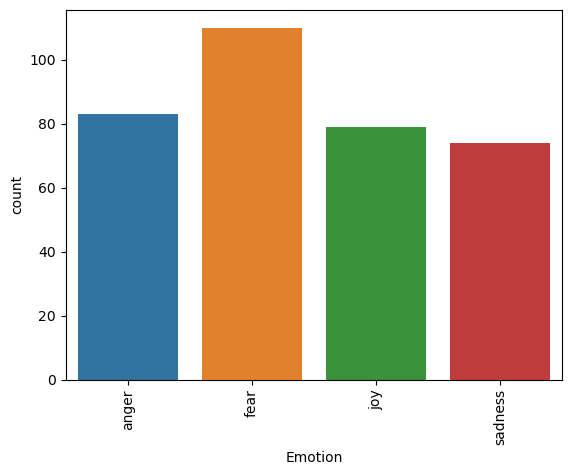

In [8]:
sns.countplot(x=train_data['Emotion'])
plt.xticks(rotation=90)
plt.show()

# Cleaning and preprocessing the data

In [9]:
def clean_and_preprocess_text(text):
    # Clean text using preprocessor
    text = p.clean(text)

    # Tokenize the tweet using a custom tokenizer that handles contractions
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    word_tokens = tokenizer.tokenize(text)
    
    # Handle contractions (e.g., "don't" -> "do not")
    contractions_handled = []
    for word in word_tokens:
        if "'" in word:
            expanded = contractions.fix(word)
            contractions_handled.extend(expanded.split())
        elif word == 'dont':
            contractions_handled.append('not')
        else:
            contractions_handled.append(word)

    # Stop word removal and length filtering
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    filtered_text = [word for word in contractions_handled if word.isalnum() and len(word) > 3 and word.lower() not in stop_words]

    # Lowercase change
    text = ' '.join(filtered_text).lower()

    # Lemmatization using WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    text = ' '.join(lemmatized_words)

    # Text normalization steps
    def normalize_text(words):
        p = inflect.engine()
        new_words = []
        for word in words:
            word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            word = word.lower()
            word = re.sub(r'[^\w\s]', '', word)
            if word.isdigit():
                word = p.number_to_words(word)
            new_words.append(word)
        return new_words

    # Tokenize and preprocess text
    words = nltk.word_tokenize(text)
    preprocessed_text = ' '.join(normalize_text(words))
    
    return preprocessed_text

# Process text
train_data['CleanedText'] = train_data['Text'].apply(clean_and_preprocess_text)

# Display the cleaned DataFrame
print(train_data['CleanedText'].head(10))


0           would almost took offense actually snapped
1    rutgers game abomination affront must never speak
2                       lisa asked started raging call
3    sometimes something minuscule ruin somebody li...
4    sometimes something minuscule ruin somebody li...
5    think must actually working like havent snap c...
6    eye dilated hate world right rage thousand fie...
7    chosen member seat people dole mate elect cand...
8    chosen member seat people dole mate elect cand...
9         please canadian player play player atrocious
Name: CleanedText, dtype: object


# Duplicate data in cleaned text column

In [10]:
train_data['CleanedText'].duplicated().sum()

56

In [11]:
train_data[train_data['CleanedText'].duplicated() == True]

,Text,Emotion,CleanedText
4,Sometimes I get mad over something so minuscul...,anger,sometimes something minuscule ruin somebody li...
8,@huwellwell One chosen by the CLP members! MP ...,anger,chosen member seat people dole mate elect cand...
13,Sorry guys I have absolutely no idea what time...,anger,sorry guy absolutely idea time tomorrow keep p...
15,"Is it me, or is Ding wearing the look of a man...",anger,ding wearing look found arch enemy missus
22,@TrueAggieFan oh so that's where Brian was! Wh...,anger,brian invite
35,@pbhushan1 @IndianExpress so in your opinion i...,anger,opinion worst delhi govt
42,"Kik to trade, have fun or a conversation (kik...",anger,trade conversation youraffair
49,Just joined #pottermore and was sorted into HU...,anger,joined sorted hufflepuff
53,Having a baby born too soon is #lifechanging 6...,anger,baby born soon year feel like yesterday
62,"Why to have vanity sizes?Now sizes S,XS(evenXX...",anger,vanity size size evenxxs sometimes dear corpor...


In [12]:
# seeing some of duplicated rows
train_data[train_data['CleanedText'] == train_data.iloc[155]['CleanedText']]

,Text,Emotion,CleanedText
154,About 7 weeks till I can pick up my camera aga...,fear,week till pick camera though think group cemet...
155,About 7 weeks till I can pick up my camera aga...,fear,week till pick camera though think group cemet...


In [13]:
#removing duplicated values
index = train_data[train_data['CleanedText'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)

# <span style="color:green;">1. Using Rule-based approach</span>

In [14]:
# Step 1: Separate data by emotions
emotions_data = {}
for emotion in train_data['Emotion'].unique():
    emotions_data[emotion] = train_data[train_data['Emotion'] == emotion]['CleanedText']

# Step 2: Tokenize the text within each emotion
tokenized_emotions = {}
for emotion, texts in emotions_data.items():
    tokenized_emotions[emotion] = ' '.join(texts).split()

# Step 3: Count the frequency of each token for each emotion
word_frequencies = {}
for emotion, tokens in tokenized_emotions.items():
    word_frequencies[emotion] = Counter(tokens)

# Step 4: Identify the intersection of the most frequent words across all emotions
common_words = set(word_frequencies[next(iter(word_frequencies))].keys())

for emotion, frequencies in word_frequencies.items():
    common_words &= set(frequencies.keys())

# Get the most frequent mutual words
num_top_words = 20 
most_frequent_words = Counter({word: sum(word_frequencies[emotion][word] for emotion in word_frequencies) for word in common_words}).most_common(num_top_words)

print("Most frequent mutual words:")
for word, count in most_frequent_words:
    print(f"{word}: {count}")

Most frequent mutual words:
would: 21
like: 21
want: 12
make: 11
think: 11
love: 10
even: 8
much: 8
look: 7
keep: 6
today: 6
year: 6
everyone: 6
something: 6
life: 6


In [15]:
def remove_word(text):
    # List of most frequent mutual words to be removed
    words_to_remove = ['like', 'would', 'want', 'think', 'make', 'love', 'much', 'even', 'look', 'today', 'something', 'keep', 'year', 'everyone', 'life']

    # Function to remove specified words from a text
    return ' '.join([word for word in text.split() if word.lower() not in words_to_remove])

# Apply the function to the 'CleanedText' column
train_data['CleanedText'] = train_data['CleanedText'].apply(remove_word)


In [16]:
emotion_keywords = {
    'joy': ['admire', 'admiration', 'awe', 'baffle', 'bewilder', 'dazed', 'dumbfound','surprise', 'shock', 'amaze', 'astonish', 'worship', 'satisfy', 'pride', 'love', 'joy', 'happy', 'delight', 'pleasure'],
    'anger': ['angry', 'mad', 'irritated', 'frustrated', 'wrath', 'umbrage', 'infuriation', 'fury', 'annoyance', 'anger'],
    'fear': ['terror', 'dread','apprehension', 'timidity', 'suspense', 'panic', 'fear', 'intimidation', 'hysteria', 'horror', 'cruelty', 'creeps', 'alarm'],
    'sadness': ['despair', 'hopeless', 'lonely', 'woe', 'weepiness', 'sorrow', 'sadness', 'repentance', 'misery', 'melancholy', 'jolyless', 'guilt', 'sad', 'unhappy', 'grief', 'depressed', 'displeasing','hate', 'dislike', 'loathe', 'despise']
}

def rule_based_emotion_detection(text):
    for emotion, keywords in emotion_keywords.items():
        if any(keyword in text for keyword in keywords):
            return emotion
    return train_data['Emotion']

# Showing the first 20 most frequent words

In [17]:
# TF IDF vectorizer with adjusted parameters
tfidf_vect = TfidfVectorizer()

# Fit and transform
matrix_tfidf = tfidf_vect.fit_transform(train_data['CleanedText'])
# Using get_feature_names_out
featureNames = tfidf_vect.get_feature_names_out()

# Data frame for our matrix_tfidf and featureNames
df_tfidf = pd.DataFrame(data=matrix_tfidf.toarray(), columns=featureNames)

# Adding up the importance scores (= TF-IDF scores) for every word.
wordScores = df_tfidf.sum(axis=0)

# Sorting words according to how much they matter in all the tweets
# Sorting them with their overall TF-IDF scores.
top20words = wordScores.sort_values(ascending=False).head(20)

# Print top20words
print(top20words)

people      3.651387
thing       3.401614
feel        2.655581
know        2.396599
awful       2.356364
issue       2.352816
week        2.329235
little      2.303333
give        2.246074
terrible    2.138867
game        2.127636
always      2.093888
miss        2.082721
really      2.057636
ever        2.019763
good        2.007824
time        1.969771
scare       1.936130
never       1.928885
happy       1.843391
dtype: float64


# Showing the most frequent words associated with each emotion in graph

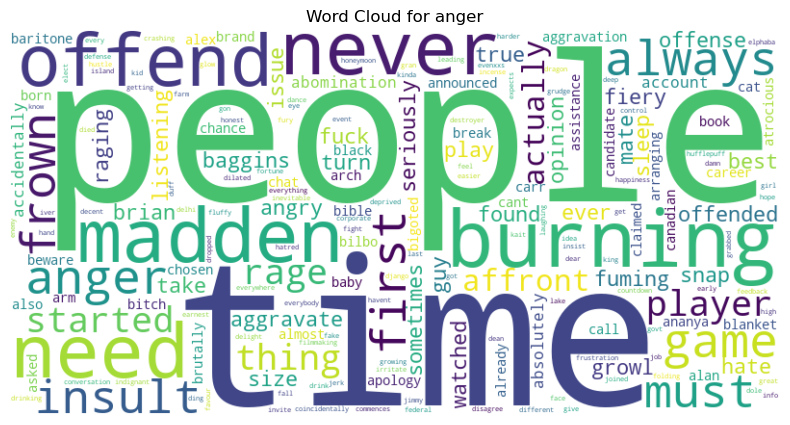

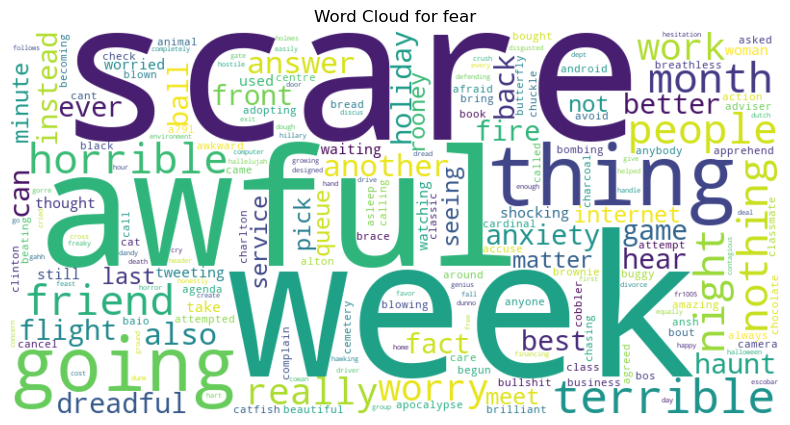

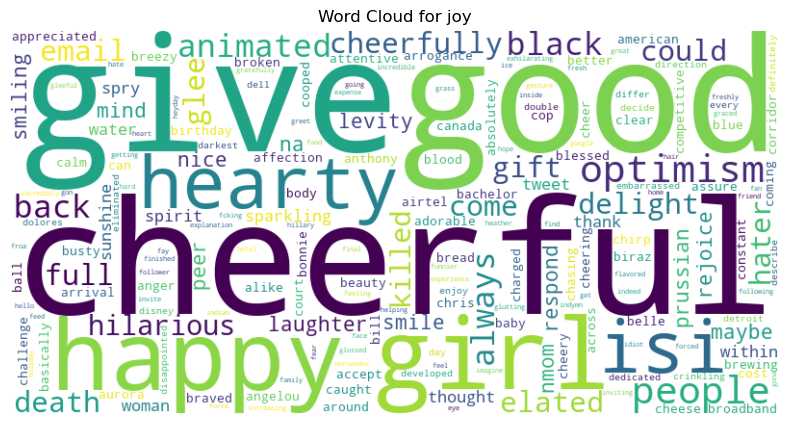

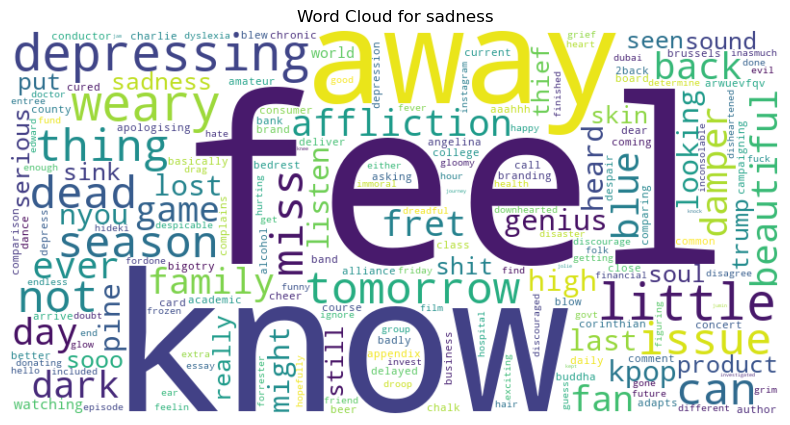

In [18]:
# Define emotions
emotions = train_data['Emotion'].unique()

# Create a dictionary to store unigram frequencies for each emotion
unigram_freq_dict = {}

# Loop through each emotion and perform unigram analysis
for emotion in emotions:
    # Filter data for the current emotion
    subset_data = train_data[train_data['Emotion'] == emotion]

    # Initialize CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the text data
    X = vectorizer.fit_transform(subset_data['CleanedText'])

    # Get feature names (unigrams)
    feature_names = vectorizer.get_feature_names_out()

    # Get the sum of each feature (unigram) across all tweets for the current emotion
    word_frequencies = X.sum(axis=0)

    # Create a dictionary of unigram frequencies
    word_freq_dict = {word: word_frequencies[0, idx] for word, idx in zip(feature_names, range(len(feature_names)))}

    # Sort the dictionary by frequency in descending order
    sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

    # Store the sorted dictionary in the main dictionary
    unigram_freq_dict[emotion] = sorted_word_freq


# Function to generate and display word cloud for a given emotion
def generate_word_cloud(emotion, words_freq):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_freq))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion}')
    plt.show()

# Loop through each emotion and generate word clouds
for emotion, top_words in unigram_freq_dict.items():
    generate_word_cloud(emotion, top_words)


# Text augmentation using synonym replacement

In [19]:
import nlpaug.augmenter.word as naw

# Function to apply text augmentation using synonym replacement
def augment_text(text, aug_p=0.2):
    aug = naw.SynonymAug(aug_p=aug_p)
    augmented_text_list = aug.augment(text)
    augmented_text_str = ' '.join(augmented_text_list)
    return augmented_text_str

num_augmentations = 5  # You can adjust this as needed
for i in range(1, num_augmentations + 1):
    column_name = f'AugmentedText{i}'
    train_data[column_name] = train_data['CleanedText'].apply(augment_text)

augmented_columns = [f'AugmentedText{i}' for i in range(1, num_augmentations + 1)]
combined_text = pd.concat([train_data['CleanedText']] + [train_data[col] for col in augmented_columns], ignore_index=True)
combined_emotion = pd.concat([train_data['Emotion']] * (num_augmentations + 1), ignore_index=True)
df = pd.DataFrame({'Text': combined_text, 'Emotion': combined_emotion})

df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame
df = df.dropna().reset_index(drop=True)


In [20]:
df

,Text,Emotion
0,ding wearing found puckish enemy missis,anger
1,lamentable part whole mess march,anger
2,peer eye crinkling mirth affection bonnie belle,joy
3,great mind similar,joy
4,decent song dynasty,anger
...,...,...
1735,true nthey burning pleasure nppl true happines...,anger
1736,beware fury weak king,anger
1737,beware fury weak king,anger
1738,depress comparing equivalence,sadness


# <span style="color:darkorange;">Point: For the following part download "glove.6B.50d.txt" file.</span>
### GloVe embeddings are employed in emotion detection from text due to their capacity to capture semantic meaning by leveraging pre-trained knowledge from large corpora. These embeddings, which represent words in a lower-dimensional space, contribute to efficient model training, reducing the risk of overfitting. The pre-training on extensive linguistic data enables transfer learning, allowing models to generalize effectively even when specific emotion-labeled data is limited. GloVe embeddings enhance the understanding of nuanced language expressions, improving the recognition of emotional context and aiding in building more robust and generalized emotion detection models.
#### Resource: https://www.kaggle.com/datasets/watts2/glove6b50dtxt

# Load GloVe embeddings

In [21]:
# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_file_path = 'glove.6B.50d.txt'  
glove_embeddings = load_glove_embeddings(glove_file_path)

# Function to get word embeddings for a text
def get_word_embeddings(text):
    embeddings = []
    for word in text.split():
        if word in glove_embeddings:
            embeddings.append(glove_embeddings[word])
    return np.mean(embeddings, axis=0) if embeddings else np.zeros_like(list(glove_embeddings.values())[0])

# Apply word embeddings to each row in the dataset
df['WordEmbeddings'] = df['Text'].apply(get_word_embeddings)

# <span style="color:green;">2. Machine learning approach</span>
# Training and evaluation

In [22]:
X = np.vstack(df['WordEmbeddings'].to_numpy())
y = df['Emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Create and train the SVC model
SVC = SVC()
SVC.fit(X_train, y_train)
# Make predictions on the test set
y_pred_dt = SVC.predict(X_test)

# Evaluate the model
print("SVC Report:")
print(classification_report(y_test, y_pred_dt, zero_division=1))

SVC Report:
              precision    recall  f1-score   support

       anger       0.81      0.77      0.79        84
        fear       0.77      0.83      0.79       103
         joy       0.74      0.79      0.76        80
     sadness       0.79      0.70      0.75        81

    accuracy                           0.78       348
   macro avg       0.78      0.77      0.77       348
weighted avg       0.78      0.78      0.78       348



In [24]:
# Create and train the Logistic Regression model
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_logistic = logistic_regression_classifier.predict(X_test)

# Evaluate the model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic, zero_division=1))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       anger       0.60      0.58      0.59        84
        fear       0.58      0.68      0.63       103
         joy       0.60      0.62      0.61        80
     sadness       0.65      0.51      0.57        81

    accuracy                           0.60       348
   macro avg       0.61      0.60      0.60       348
weighted avg       0.61      0.60      0.60       348



In [25]:
# Create and train the Random Forest model
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_rf = random_forest_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=1))


Random Forest Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.83      0.87        84
        fear       0.86      0.93      0.90       103
         joy       0.92      0.95      0.93        80
     sadness       0.95      0.90      0.92        81

    accuracy                           0.91       348
   macro avg       0.91      0.90      0.91       348
weighted avg       0.91      0.91      0.90       348



In [26]:
# Create and train the Decision Tree model
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_dt = decision_tree_classifier.predict(X_test)

# Evaluate the model
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=1))


Decision Tree Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.77      0.73        84
        fear       0.73      0.72      0.72       103
         joy       0.75      0.82      0.79        80
     sadness       0.71      0.56      0.62        81

    accuracy                           0.72       348
   macro avg       0.72      0.72      0.71       348
weighted avg       0.72      0.72      0.72       348



# <span style="color:darkviolet;">Using Random Forest to label the test dataset</span>

In [30]:
# Load the test dataset without column names
test_data = pd.read_excel("test_dataset.xlsx", header=None)
test_data = test_data.drop(test_data.columns[1], axis=1)
# Assuming the test dataset structure based on the provided example
test_data.columns = ['Text']

# Apply the same cleaning and preprocessing steps to the test dataset
test_data['CleanedText'] = test_data['Text'].apply(clean_and_preprocess_text)

# Apply word embeddings to the test dataset
test_data['WordEmbeddings'] = test_data['CleanedText'].apply(get_word_embeddings)

# Get the feature matrix for the test set
X_test = np.vstack(test_data['WordEmbeddings'].to_numpy())

# Use the trained Random Forest model to make predictions on the test set
y_pred_test = random_forest_classifier.predict(X_test)

# Add the predicted labels to the test dataset
test_data['PredictedEmotion'] = y_pred_test

# Display the test dataset with predicted labels
print(test_data[['Text', 'PredictedEmotion']])

# Save the test_data DataFrame to an Excel file
test_data[['Text', 'PredictedEmotion']].to_excel("predicted_test_results.xlsx", index=False)

                                                   Text PredictedEmotion
0     At the point today where if someone says somet...             fear
1     @CorningFootball  IT'S GAME DAY!!!!      T MIN...          sadness
2     This game has pissed me off more than any othe...          sadness
3     @spamvicious I've just found out it's Candice ...            anger
4     @moocowward @mrsajhargreaves @Melly77 @GaryBar...             fear
...                                                 ...              ...
3137    Why does Candice constantly pout #GBBO üíÑüòí              joy
3138  @redBus_in #unhappy with #redbus CC, when I ta...             fear
3139  @AceOperative789 no pull him afew weeks ago, s...             fear
3140  I'm buying art supplies and I'm debating how s...              joy
3141  @sainsburys Could you ask your Chafford Hundre...              joy

[3142 rows x 2 columns]


# <span style="color:red;">Report</span>

## <span style="color:blue;">1. What text cleaning approaches did you use?</span>

In the text cleaning process, several approaches were employed to enhance the quality and uniformity of the textual data. Initially, the preprocessor library was utilized to eliminate URLs, mentions, hashtags, and other Twitter-specific elements from the text. Subsequently, the TweetTokenizer was employed for tokenization, ensuring the proper handling of Twitter-specific tokens and contractions. Contractions were further addressed using the contractions library. Stop words were removed, and short or non-alphanumeric tokens were filtered out to enhance the relevance of the remaining words. The text was then lowercased, and lemmatization was performed using the WordNet Lemmatizer to standardize word forms. Furthermore, text normalization included converting numerical values to words and handling Unicode characters. Additionally, specific common words identified within the dataset were systematically removed, contributing to a refined and standardized textual representation.

## <span style="color:blue;">2. What is the emotion detection approach used in this workshop? How did you evaluate your work?</span>
The emotion detection approach employed in this workshop adopts a machine learning methodology, leveraging GloVe word embeddings to represent text in a continuous vector space. The preprocessed text data undergoes transformation into feature vectors using the average of the word embeddings for each word within a tweet. The four machine learning models employed—Support Vector Classifier (SVC), Logistic Regression, Random Forest, and Decision Tree—are trained on these feature vectors to classify tweets into four distinct emotion categories: anger, fear, joy, and sadness. Evaluation of model performance is conducted using classification reports, which provide detailed metrics such as precision, recall, and F1-score for each emotion class. This comprehensive approach combines the power of word embeddings with various classifiers, ensuring a robust evaluation of the models' effectiveness in emotion detection on a test set.

Between classifiers the Random Forest model exhibits high precision, recall, and F1-scores for each emotion category, culminating in an impressive overall accuracy of 91%, affirming its robust performance in emotion detection on the provided test dataset.

The Random Forest classification report provides a detailed assessment of the model's performance across multiple metrics for each emotion category. In the context of this report:

Precision: Represents the accuracy of positive predictions, indicating how many of the predicted instances for each emotion were correct. For anger, joy, and sadness, the precision values are high, ranging from 0.91 to 0.95, suggesting a low rate of false positives. Fear also exhibits substantial precision at 0.86.

Recall: Reflects the model's ability to identify and capture instances of each emotion among the total true instances. The recall values for all emotions are notable, ranging from 0.83 to 0.95, indicating a high capability to capture the true positive instances.

F1-Score: Represents the harmonic mean of precision and recall, providing a balanced measure of the model's overall performance. The F1-scores for all emotions are high, ranging from 0.87 to 0.93, demonstrating a strong balance between precision and recall.

Support: Indicates the actual number of instances for each emotion in the test set. The support values vary across emotions but collectively contribute to the overall assessment.

Accuracy: Represents the overall correct predictions out of the total instances, yielding an accuracy of 91%. This value emphasizes the model's effectiveness in correctly classifying emotions across all categories.

## <span style="color:blue;">3. What challenges did you face in order to identify emotions?</span>

Identifying emotions in text presents several challenges that impact the overall effectiveness of emotion detection models. One significant hurdle is the limited amount of data available for training, as the dataset might be relatively small, hindering the models' ability to generalize well to diverse expressions of emotions. To mitigate this issue, I employed text augmentation techniques to artificially expand the dataset and enhance the accuracy of the models by introducing additional variations in the training data. Another challenge stems from the subjectivity inherent in emotion labeling, as different annotators may interpret and categorize emotions differently, leading to variations in ground truth annotations. Additionally, the ambiguity present in textual expressions of emotions poses a difficulty, as emotions can be conveyed in diverse ways, and some nuanced expressions may be challenging to accurately categorize. Lastly, imbalanced classes, where certain emotions are unevenly distributed in the dataset, pose a challenge to the model's performance, as it may become biased towards the more prevalent emotions. Addressing these challenges requires careful consideration of data augmentation strategies, fine-tuning of models, and exploring techniques to handle subjective and ambiguous aspects of emotional expressions in text.

## <span style="color:blue;">4. What are your suggestions to further improve your method?</span>
    Hyperparameter Tuning: Experiment with different hyperparameter settings for the machine learning models to optimize performance.
    
    Ensemble Models: Combine predictions from multiple models to enhance overall accuracy and robustness.
    
    Deep Learning Approaches: Consider exploring deep learning models, such as recurrent neural networks (RNNs) or transformers, for more sophisticated emotion detection.
    
    Domain-Specific Pretraining: Pretrain models on a larger, domain-specific dataset to capture domain-specific nuances.
    
    Addressing Imbalanced Classes: Implement techniques like oversampling or undersampling to address imbalances in class distribution.
    
    Fine-Tuning Embeddings: Fine-tune pre-trained word embeddings or experiment with different embeddings for better representation of emotions.
    
    User Feedback Loop: Incorporate a user feedback loop to continuously improve and adapt the model based on real-world performance and user input.